##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import ipaddress
from urllib.parse import urlparse
from urllib.parse import urlparse, parse_qs
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

##Load Dataset

In [2]:
dataset = pd.read_csv(r"C:\Users\LOQ\Downloads\malicious_phish.csv")

##Initial Data Overview

In [3]:
print("----------------------- Initial Data Head -----------------------")
dataset.head()

----------------------- Initial Data Head -----------------------


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


##Check for nulls

In [6]:
null_counts = dataset.isnull().sum()
print("----------------------- Null Values per Column -----------------------")
null_counts

----------------------- Null Values per Column -----------------------


,0
url,0
type,0


## Check for duplicates

In [7]:
duplicate_count = dataset.duplicated().sum()
print("----------------------- Total Duplicates: -----------------------")
duplicate_count

----------------------- Total Duplicates: -----------------------


10066

## Rows Per column

In [8]:
dataset['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


## Description of dataset

In [9]:
dataset.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


## Converting the URL column to lower case and then removing duplicates from it

In [3]:
dataset['url'] = dataset['url'].str.lower()
dataset.drop_duplicates(subset=['url'])

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/dead-space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/dead_space_(video_game),phishing


# Feature Engineering

### 1. Calculate URL length

In [4]:
dataset['url_length'] = dataset['url'].str.len()

dataset.head()

,url,type,url_length
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


### 2. Count Specific Characters (/, ., -, ?, =)

In [5]:
dataset['count_slash'] = dataset['url'].str.count('/')
dataset['count_dot'] = dataset['url'].str.count(r'\.')
dataset['count_dash'] = dataset['url'].str.count('-')
dataset['count_question'] = dataset['url'].str.count(r'\?')
dataset['count_equals'] = dataset['url'].str.count('=')

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals
0,br-icloud.com.br,phishing,16,0,2,1,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3


### 3. Count all special characters

In [6]:
def count_special_char(url):
    non_alpha_char = re.findall(r'\W', url)
    return len(non_alpha_char)

dataset['special_chars_count'] = dataset['url'].apply(count_special_char)

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13


### 4. Count Digits

In [7]:
def count_digits(url):
    digits = re.findall(r'\d', url)
    return len(digits)


dataset['digits_count'] = dataset['url'].apply(count_digits)

dataset

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22
...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3,3,0,0,0,6,12
651187,games.teamxbox.com/xbox-360/1860/dead-space/,phishing,44,4,2,2,0,0,8,7
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,4,2,0,0,0,6,3
651189,en.wikipedia.org/wiki/dead_space_(video_game),phishing,45,2,2,0,0,0,6,0


### 5. Count Letters

In [8]:
def count_letters(url):
    letters = re.findall(r'[a-zA-Z]', url)
    return len(letters)


dataset['letters_count'] = dataset['url'].apply(count_letters)

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199


### 6. Check if the URL contains an IP address

In [9]:
def has_ip_address(url):
    try:
        parsed_url = urlparse(url)
        hostname = parsed_url.hostname or parsed_url.path  # Get hostname or fallback to path
        ip = ipaddress.ip_address(hostname)  # Check if the hostname is a valid IP
        return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        return 0

# Apply the function to the DataFrame
dataset['has_ip'] = dataset['url'].apply(has_ip_address).astype(int)

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0


### 7. Count URL parameters

In [10]:
def count_url_parameters(url):
    # Parse the URL using urlparse
    parsed_url = urlparse(url)

    # Extract the query part of the URL
    query = parsed_url.query

    # Parse the query parameters using parse_qs
    parameters = parse_qs(query)

    # Return the number of parameters
    return len(parameters)


dataset['param_count'] = dataset['url'].apply(count_url_parameters)
dataset

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3,3,0,0,0,6,12,21,0,0
651187,games.teamxbox.com/xbox-360/1860/dead-space/,phishing,44,4,2,2,0,0,8,7,29,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,4,2,0,0,0,6,3,33,0,0
651189,en.wikipedia.org/wiki/dead_space_(video_game),phishing,45,2,2,0,0,0,6,0,36,0,0


### 8. Check if the URL has 'php' and 'html'

In [11]:
def check_php_in_url(url):
    # Check if the term 'php' is present in the URL (case-insensitive)
    if 'php' in url.lower():
        return 1
    else:
        return 0


def check_html_in_url(url):
    # Check if the term 'html' is present in the URL (case-insensitive)
    if 'html' in url.lower():
        return 1
    else:
        return 0

dataset['has_php'] = dataset['url'].apply(check_php_in_url)
dataset['has_html'] = dataset['url'].apply(check_html_in_url)
dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3,1,0


### 9. Check suspicious words

In [12]:
# List of suspicious keywords
malicious_keywords = ["login", "secure", "verify", "update", "confirm"]

# Function to check for suspicious keywords in the URL
def contains_malicious_keywords(url):
    url_lower = url.lower()  # Convert to lowercase for case-insensitive matching
    if any(keyword in url_lower for keyword in malicious_keywords):
        return 1
    return 0

url = "http://secure-login.example.com"
print(contains_malicious_keywords(url))

1


In [13]:
dataset['has_malicious_keywords'] = dataset['url'].apply(contains_malicious_keywords)

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0,0,1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3,1,0,0


### 10. Check Top Level Domains (TLD)

In [14]:
tld_list = [
    '.tk', '.buzz', '.xyz', '.top', '.ga', '.ml', '.info', '.cf', '.gq', '.icu', '.wang', '.live', '.host', '.shop' , '.top', '.icu', '.vip', '.id', '.cc', '.br', '.ci', '.zw', '.sx', '.mw'
]

def check_mal_tld(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc.lower()

    if any(netloc.endswith(tld) for tld in tld_list):
        return 1
    return 0

url = "http://example.xyz/path"
print(check_mal_tld(url))

1


In [15]:
dataset['mal_tld'] = dataset['url'].apply(check_mal_tld)

dataset[dataset['mal_tld'] == 1]

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords,mal_tld
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3,1,0,0,0


### 11. Domain Name Length

In [16]:
def extract_domain_length(url):
    try:
        # Add 'http://' if no scheme is present
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        parsed_url = urlparse(url)
        domain = parsed_url.netloc

        # Return the length of the domain
        return len(domain) if domain else 0

    except Exception as e:
        return 0

extract_domain_length('br-icloud.com.br')

16

In [17]:
dataset['domain_length'] = dataset['url'].apply(extract_domain_length)

In [18]:
# Due to incompatibale URLs, removing URLs having 0 values in domain_length

dataset = dataset[dataset['domain_length'] != 0]
dataset[dataset['domain_length'] == 0]

dataset.head()

,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords,mal_tld,domain_length
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0,0,0,0,0,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0,0,1,0,0,11
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0,0,0,0,0,14
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4,1,0,0,0,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3,1,0,0,0,23


### 12. Check http

In [19]:
def check_http(url):
    if url.startswith('http://'):
        return 1
    else:
        return 0
check_http('http://www.garage-pirenne.be/index.php?option')

1

In [20]:
dataset.loc[:,'check_http'] = dataset['url'].apply(check_http)
dataset.head()

C:\Users\LOQ\AppData\Local\Temp\ipykernel_11024\2340906294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'check_http'] = dataset['url'].apply(check_http)


,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords,mal_tld,domain_length,check_http
0,br-icloud.com.br,phishing,16,0,2,1,0,0,3,0,13,0,0,0,0,0,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,2,0,0,0,4,1,29,0,0,0,1,0,0,11,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,3,2,0,0,0,5,1,25,0,0,0,0,0,0,14,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,3,1,1,4,16,7,63,0,4,1,0,0,0,21,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,3,2,1,1,3,13,22,199,0,3,1,0,0,0,23,1


### 13. Check https

In [21]:
def check_https(url):
    if url.startswith('https://'):
        return 1
    else:
        return 0
check_https('http://www.garage-pirenne.be/index.php?option')

0

In [22]:
dataset.loc[:,'check_https'] = dataset['url'].apply(check_https)
dataset[dataset['check_https'] == 1]

C:\Users\LOQ\AppData\Local\Temp\ipykernel_11024\1016083127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'check_https'] = dataset['url'].apply(check_https)


,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords,mal_tld,domain_length,check_http,check_https
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,87,4,2,0,1,1,9,5,73,0,1,0,0,0,0,15,0,1
129,https://twitter.com/home?status=%e3%83%8c%e3%8...,benign,290,3,2,1,1,1,82,90,118,0,1,0,0,0,0,11,0,1
491,https://medium.com/human-parts/the-laziest-com...,benign,113,4,1,11,1,1,19,6,88,0,1,0,0,0,0,10,0,1
772,https://hollywoodlife.com/2015/05/14/new-york-...,benign,108,7,1,10,0,0,19,9,80,0,0,0,0,0,0,17,0,1
1102,https://paytm.com/blog/vijay-shekahr-sharma-on...,benign,100,5,1,8,1,1,17,0,83,0,1,0,0,0,0,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555094,https://drive.google.com/uc?export=download&id...,malware,80,3,2,1,1,2,11,2,67,0,2,0,0,0,0,16,0,1
555118,https://onedrive.live.com/download?cid=9bef332...,malware,108,3,2,0,1,3,13,22,73,0,3,0,0,0,0,17,0,1
555119,https://onedrive.live.com/download?cid=dd0a0ec...,malware,109,3,2,0,1,3,13,20,75,0,3,0,0,0,0,17,0,1
555120,https://onedrive.live.com/download?cid=cf0c6d1...,malware,108,3,2,0,1,3,13,25,70,0,3,0,0,0,0,17,0,1


### 14. Encoding

In [23]:
mapping = {'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3}
dataset['type'] = dataset['type'].replace(mapping)
dataset.head()

C:\Users\LOQ\AppData\Local\Temp\ipykernel_11024\3938305256.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['type'] = dataset['type'].replace(mapping)
C:\Users\LOQ\AppData\Local\Temp\ipykernel_11024\3938305256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['type'] = dataset['type'].replace(mapping)


,url,type,url_length,count_slash,count_dot,count_dash,count_question,count_equals,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,has_malicious_keywords,mal_tld,domain_length,check_http,check_https
0,br-icloud.com.br,2,16,0,2,1,0,0,3,0,13,0,0,0,0,0,0,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,2,2,0,0,0,4,1,29,0,0,0,1,0,0,11,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,3,2,0,0,0,5,1,25,0,0,0,0,0,0,14,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,88,3,3,1,1,4,16,7,63,0,4,1,0,0,0,21,1,0
4,http://adventure-nicaragua.net/index.php?optio...,1,235,3,2,1,1,3,13,22,199,0,3,1,0,0,0,23,1,0


In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651173 entries, 0 to 651190
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   url                     651173 non-null  object
 1   type                    651173 non-null  int64 
 2   url_length              651173 non-null  int64 
 3   count_slash             651173 non-null  int64 
 4   count_dot               651173 non-null  int64 
 5   count_dash              651173 non-null  int64 
 6   count_question          651173 non-null  int64 
 7   count_equals            651173 non-null  int64 
 8   special_chars_count     651173 non-null  int64 
 9   digits_count            651173 non-null  int64 
 10  letters_count           651173 non-null  int64 
 11  has_ip                  651173 non-null  int32 
 12  param_count             651173 non-null  int64 
 13  has_php                 651173 non-null  int64 
 14  has_html                651173 non-null  

# Feature Selection

### 1. Separate features and target variables

In [26]:
X = dataset.drop(columns=['url', 'type'])  # Drop 'url' as it is non-numeric
y = dataset['type']

print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

X = X.dropna()
y = y.loc[X.index]

if not X.select_dtypes(include=['object']).empty:
    X = pd.get_dummies(X)

Missing values in X: 0
Missing values in y: 0


### 2. Split data into training and testing sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Feature Importance using Random Forest

In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  # Fit the model successfully
print("Random Forest trained successfully!")

Random Forest trained successfully!


### 4. Extract Feature Importance

In [29]:
# Get feature importance
importances = rf.feature_importances_

# Create a DataFrame to display feature importance
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importances_df)

                   Feature  Importance
16              check_http    0.192839
1              count_slash    0.123380
15           domain_length    0.092075
2                count_dot    0.083492
0               url_length    0.078900
6      special_chars_count    0.073610
8            letters_count    0.067915
7             digits_count    0.053775
10             param_count    0.038800
17             check_https    0.037549
11                 has_php    0.033111
5             count_equals    0.029233
3               count_dash    0.026926
9                   has_ip    0.021367
12                has_html    0.016667
13  has_malicious_keywords    0.014958
14                 mal_tld    0.008511
4           count_question    0.006891


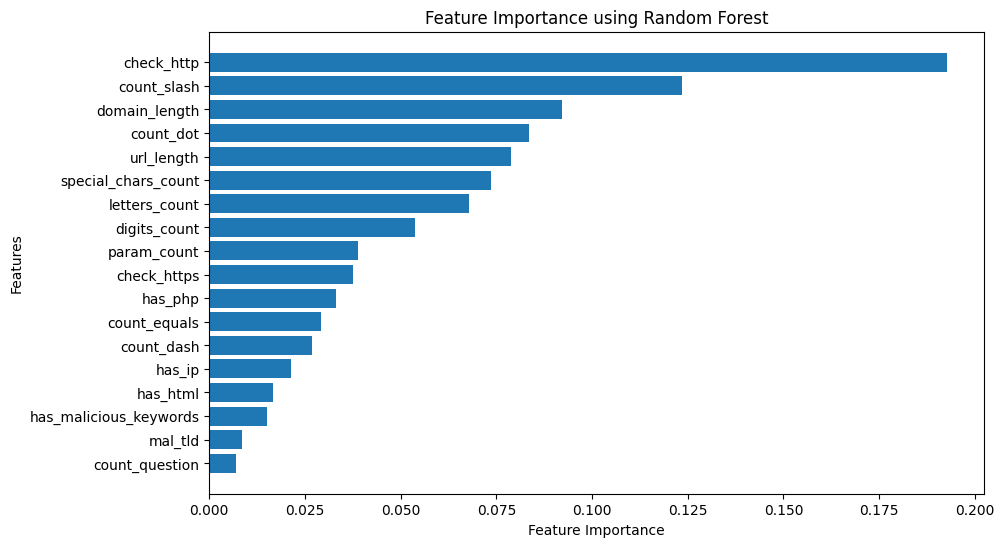

In [30]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df["Feature"], feature_importances_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.gca().invert_yaxis()
plt.show()

### 5. Select Important Features

In [31]:
threshold = 0.01
selected_features = feature_importances_df[feature_importances_df["Importance"] > threshold]["Feature"]

# Filter the dataset to keep only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

### 6. Filter the Dataset with important features

In [32]:
# Filter the dataset to include only the selected features
data_selected = dataset[selected_features]
# Add the target column back for reference
data_selected["target_column"] = y

C:\Users\LOQ\AppData\Local\Temp\ipykernel_11024\2279762256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected["target_column"] = y


In [33]:
data_selected.head()

,check_http,count_slash,domain_length,count_dot,url_length,special_chars_count,letters_count,digits_count,param_count,check_https,has_php,count_equals,count_dash,has_ip,has_html,has_malicious_keywords,target_column
0,0,0,16,2,16,3,13,0,0,0,0,0,1,0,0,0,2
1,0,2,11,2,35,4,29,1,0,0,0,0,0,0,1,0,0
2,0,3,14,2,31,5,25,1,0,0,0,0,0,0,0,0,0
3,1,3,21,3,88,16,63,7,4,0,1,4,1,0,0,0,1
4,1,3,23,2,235,13,199,22,3,0,1,3,1,0,0,0,1


### 7. Save the Filtered Dataset to a CSV File

In [ ]:
output_path = "important_features_dataset.csv"
data_selected.to_csv(output_path, index=False)
print(f"Dataset with important features saved to {output_path}")